In [1]:
import numpy as np
import glob, os, string, import_ipynb, copy
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import drawingGraph as G
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [6]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [7]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            mode_embedding[index][count] = getMode(values)
        mode_embedding[index] = np.array(mode_embedding[index])
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            values.sort()
            except_embedding[index][count] =  values[1:-1].mean()
        except_embedding[index] = np.array(except_embedding[index])
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [11]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d:
                names.append(index)#+1)
                break
    return names, ordered

In [12]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for embed in embeddings:
        if distance_measure == 'euc':
            dist.append(euclidean_distance(obj, embed))
        else:
            dist.append(cosine_distance(obj, embed))
    return dist

In [13]:
def getTopData(n, datasets, names):
    data = []
    for i in names[:n+1]:
        data.append(datasets[i])
    return data

In [14]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]), index, obj, save)

In [90]:
filename = input('filename: ')
json_file = open("model_save/mse_cce_models/last_mse_lstmae_cce.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model_save/mse_cce_models/weights_'+ filename + '.h5')

filename: last_mse_lstmae_cce


In [91]:
graph_length =1260#1080 #1260#len(glob.glob('./latest_graph_data/*')) 
embedded_length = 64

In [92]:
dir = './latest_sequence/bfs-character/graph'
#dir = './datasets/latest_seq/bfs-character/graph'

# file read
graph_group = []
all_data = []
chr_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)

for gl in range(graph_length):
    filename = dir + str(gl) + "-*"
    for file in glob.glob(filename):
        datasets = []
        chr_dts = []
        graph_group.append(file.split('/')[-1].replace('.txt', ''))
        with open(file) as f:
            for line in f.readlines():
                (u, v, w) = line[1:-2].split(', ')
                chr_dts.append([u[1], v[1], float(w)])
                datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
        chr_data.append(chr_dts)        
all_data = np.array([np.array(arr) for arr in all_data])

In [93]:
lstm_autoencoder = loaded_model

In [94]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [95]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [96]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()
mode_embedding = getEmbeddingMode()
except_embedding = getEmbeddingExceptMinMax()

In [97]:
def calcuPrecision(arr, ans):
    cnt = 0
    for a in arr:
        if int(a/210) == ans:
            cnt += 1
    return cnt

In [104]:
import random as rd

ch = [0 for i in range(graph_length)]
mode_precision = 0
avg_precision = 0
except_precision = 0
top = 51

for i in range(210, 1261, 210): #for i in range(210, 1261, 210):
    print("*********************", i)
    for idx in range(10):
        n = rd.randint(i-180, i-1) #n = rd.randint(i-210, i-1)
        #n1 = rd.randint(900+(int(i/150)-1)*60, 900+(int(i/150)*60)-1)
        while ch[n] == 1:
            n = rd.randint(i-180, i-1)#n = rd.randint(i-210, i-1)
        ch[n] = 1
        
        avg_obj = avg_embedding[n]
        mode_obj = mode_embedding[n]
        except_obj = except_embedding[n]
        
        dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
        names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)
        dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
        names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)
        dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
        names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)
        
        #print(n, names_avg_cos[1:top], names_mode_cos[1:top], names_except_cos[1:top])
        avg_precision += calcuPrecision(names_avg_cos[1:top], int(n/210))
        mode_precision += calcuPrecision(names_mode_cos[1:top], int(n/210))
        except_precision += calcuPrecision(names_except_cos[1:top], int(n/210))

********************* 210
********************* 420
********************* 630
********************* 840
********************* 1050
********************* 1260


In [105]:
if top == 11:
    print( avg_precision/600, mode_precision/600, except_precision/600)
elif top == 21:
    print( avg_precision/1200, mode_precision/1200, except_precision/1200)
elif top == 31:
    print( avg_precision/1800, mode_precision/1800, except_precision/1800)
elif top == 51:
    print( avg_precision/3000, mode_precision/3000, except_precision/3000)

0.8946666666666667 0.8543333333333333 0.8833333333333333


In [51]:
    print( avg_precision, mode_precision, except_precision)

1693 1607 1675


In [114]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, chr_data):
    index = int(n.split('-')[0].replace('graph', ''))
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            #u, v, w = row
            d.append(row)
        datasets[index] = d

In [115]:
mode_obj = mode_embedding[0]
sum_obj = sum_embedding[0]
avg_obj = avg_embedding[0]
except_obj = except_embedding[0]

In [116]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [117]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [272]:
dist_avg_euc = getDistFromEmbedding('euc', 'avg', avg_obj)
names_avg_euc, ordered_avg_euc = getGraphOrder(dist_avg_euc)

dist_sum_euc = getDistFromEmbedding('euc', 'sum', sum_obj)
names_sum_euc, ordered_sum_euc = getGraphOrder(dist_sum_euc)

dist_mode_euc = getDistFromEmbedding('euc', 'mode', mode_obj)
names_mode_euc, ordered_mode_euc = getGraphOrder(dist_mode_euc)

dist_except_euc = getDistFromEmbedding('euc', 'except', except_obj)
names_except_euc, ordered_except_euc = getGraphOrder(dist_except_euc)

In [274]:
top10_mode_euc = getTopData(10, datasets, names_mode_euc)
back10_mode_euc = getTopData(10, datasets, names_mode_euc[::-1])

top10_sum_euc = getTopData(10, datasets, names_sum_euc)
back10_sum_euc = getTopData(10, datasets, names_sum_euc[::-1])

top10_avg_euc = getTopData(10, datasets, names_avg_euc)
back10_avg_euc = getTopData(10, datasets, names_avg_euc[::-1])

top10_except_euc = getTopData(10, datasets, names_except_euc)
back10_except_euc = getTopData(10, datasets, names_except_euc[::-1])

In [118]:
# check top n results
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s, a, m, e))
    count += 1
    if count >= 21:
        break
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
#for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s, a, m, e))
    count += 1
    if count > 21:
        break
        

    sum     avg     mode    except(min, max)
       0       0       0       0
       8       8      95       8
     197     197       6     197
       1       1     574       1
     114     114      11      78
      78      78     208     114
       5       5    1216     111
      25      25     197       5
     111     111      84      90
      22      22      86      22
     107     107       5      25
      11      11     107     124
      90      90    1078     107
     124     124    1069     196
     196     196    1242      11
     208     208     427     208
     106     106     106       4
       4       4    1068     106
       6       6    1149     109
      95      95    1063      95
     109     109      75      28
    sum     avg     mode    except(min, max)
     982     982     982     982
     981     981     170     981
     352     352     981     966
     966     966     629     352
     628     628     628     629
     988     988     565     628
     629     629   

cos mode


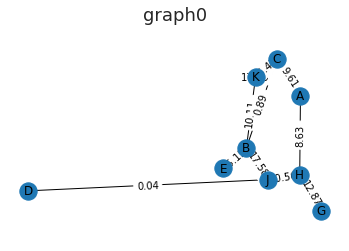

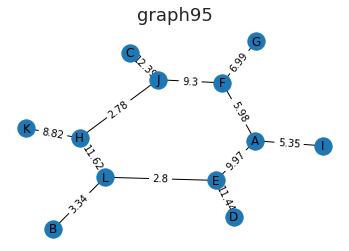

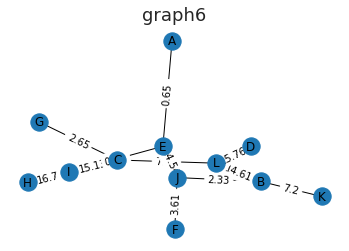

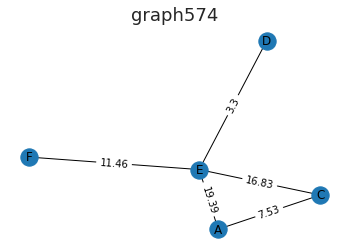

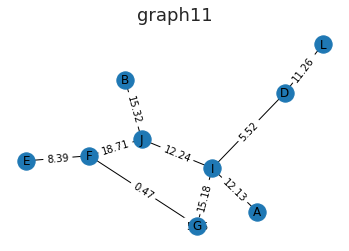

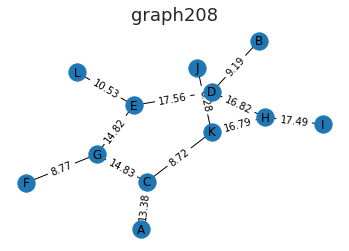

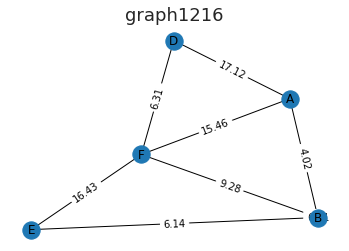

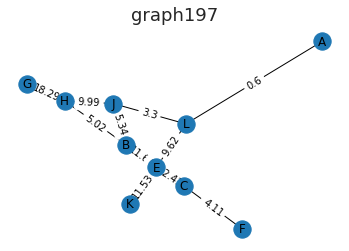

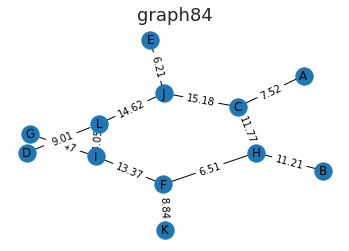

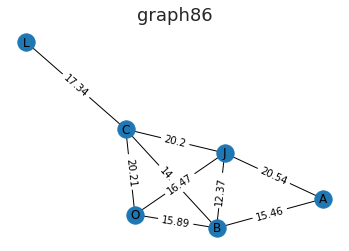

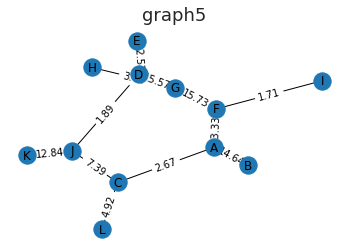

In [119]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

cos except min max


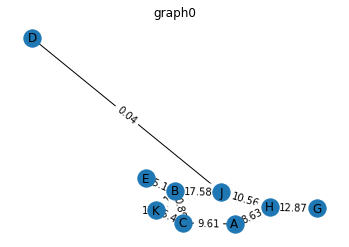

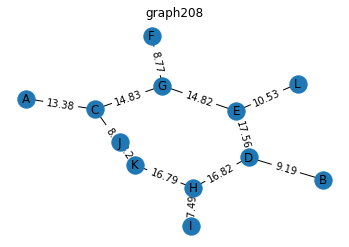

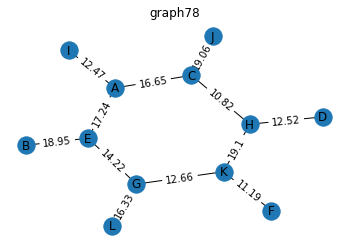

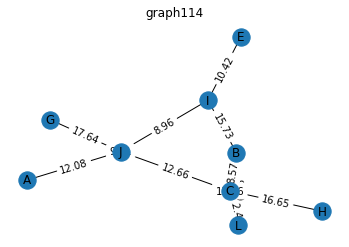

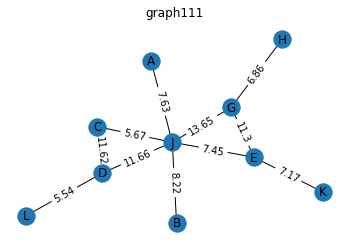

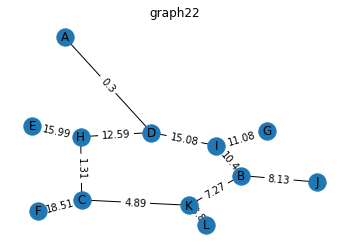

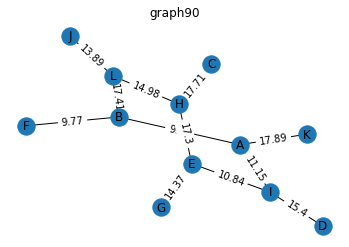

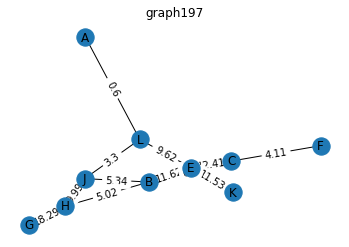

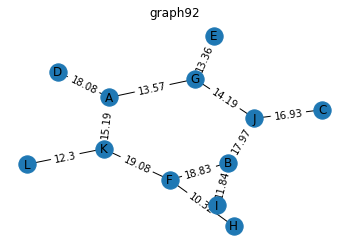

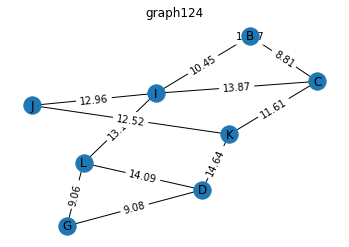

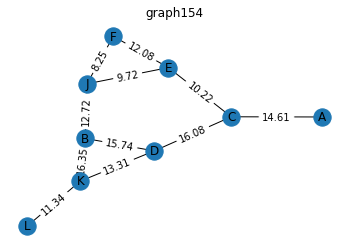

In [83]:
print("cos except min max")
draw(top10_except_cos, names_except_cos, '', False)

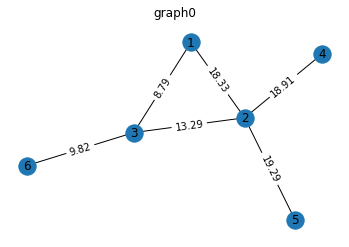

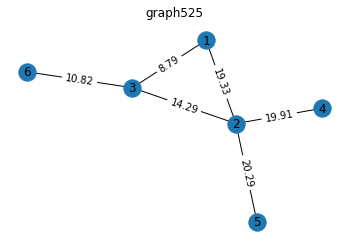

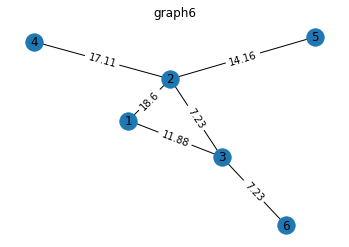

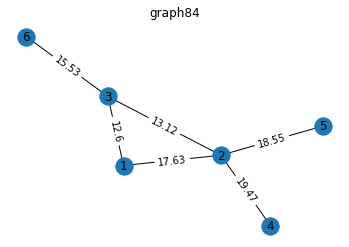

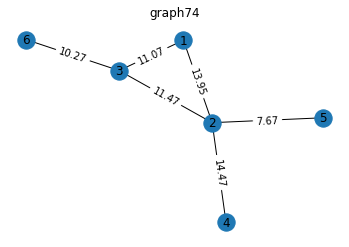

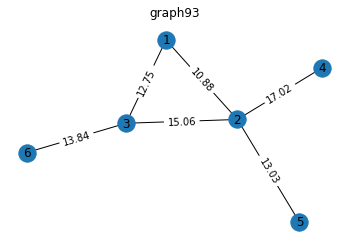

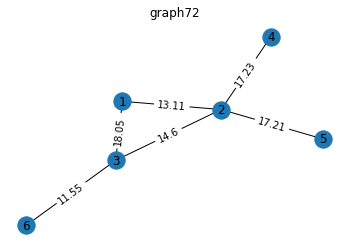

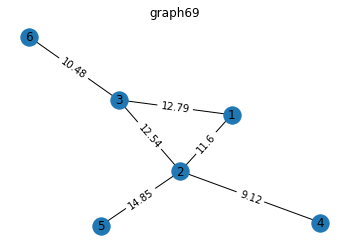

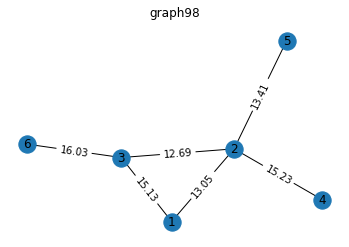

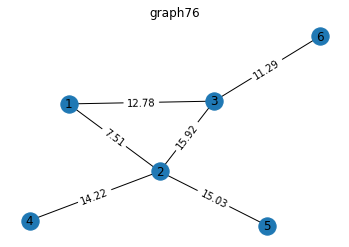

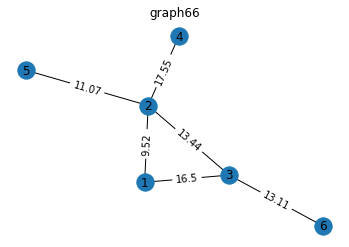

In [30]:
draw(top10_sum_cos, names_sum_cos, '', False)

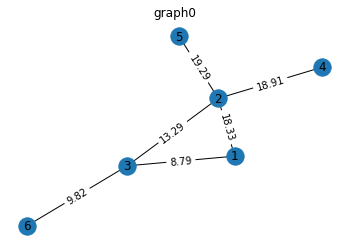

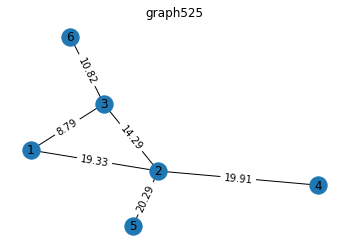

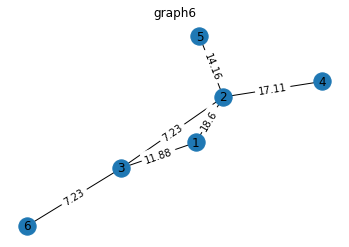

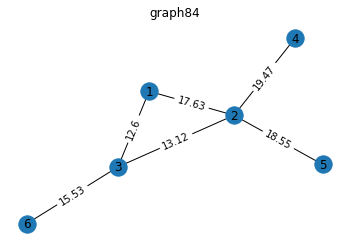

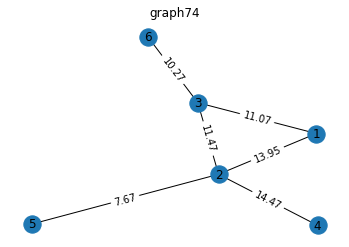

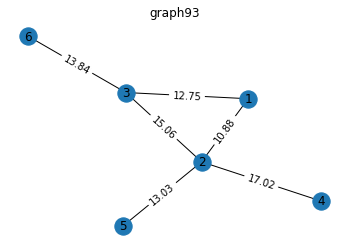

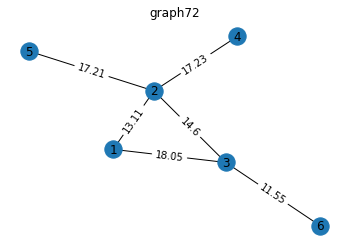

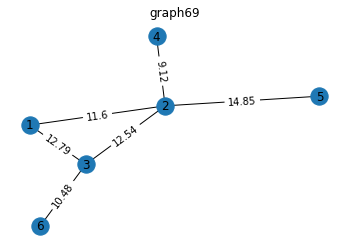

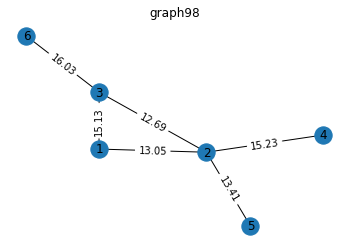

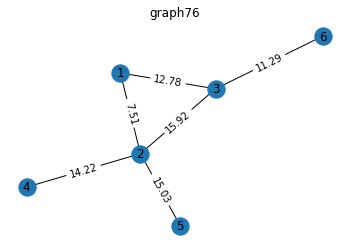

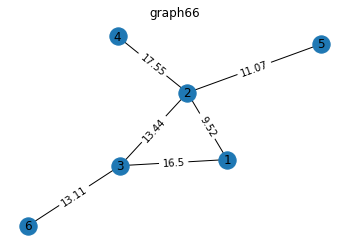

In [31]:
draw(top10_avg_cos, names_avg_cos, '', False)

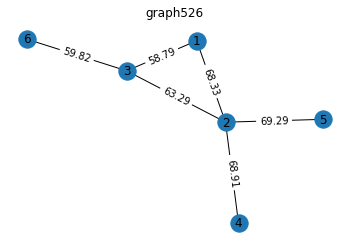

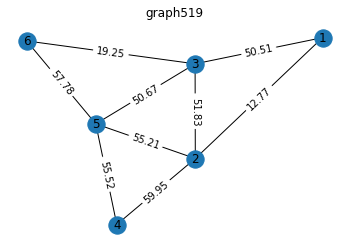

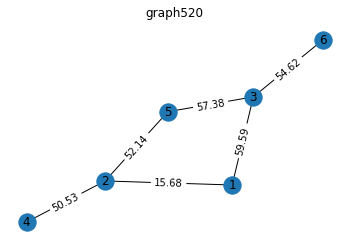

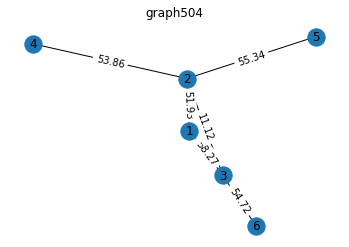

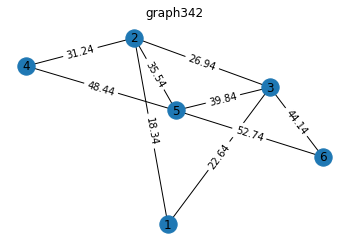

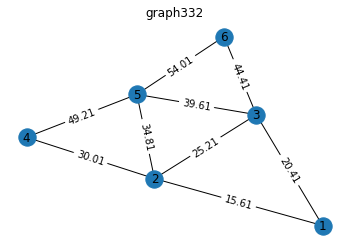

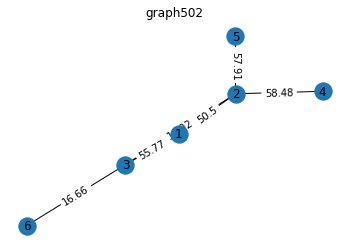

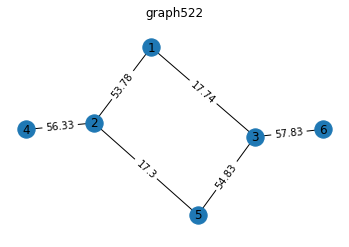

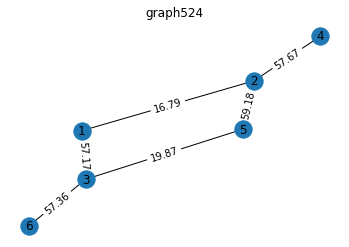

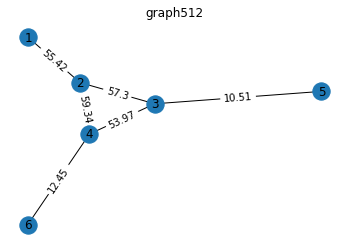

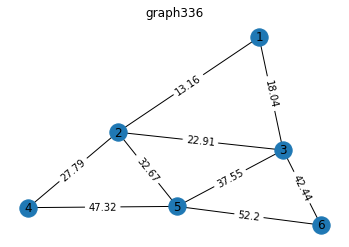

In [32]:
draw(back10_except_cos, names_except_cos[::-1], '', False)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1260 samples in 0.001s...
[t-SNE] Computed neighbors for 1260 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1260
[t-SNE] Computed conditional probabilities for sample 1260 / 1260
[t-SNE] Mean sigma: 0.151428
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.802010
[t-SNE] KL divergence after 1000 iterations: 0.761517


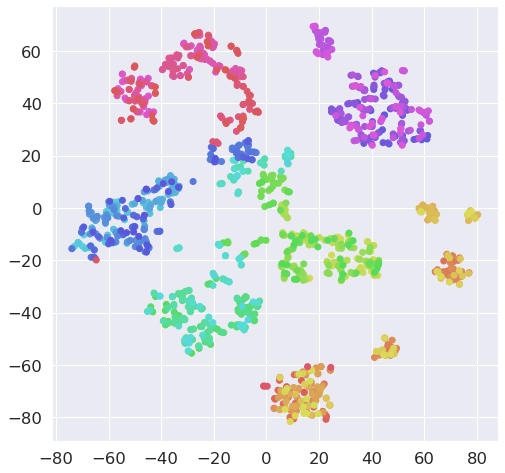

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(len(except_embedding))]
tsne_train_xs = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000).fit_transform(except_embedding, labels)
plt.figure(figsize=(8, 8))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", len(except_embedding)))

#for i in [0, 501, 525, 526]:
#    plt.annotate(str(i), (tsne_train_xs[i, 0], tsne_train_xs[i, 1]))


plt.show()